# Reverse Engineering Agoda's Sorting Algorithm

In this notebook, we aim to reverse engineer Agoda's internal sorting mechanism for hotel listings within a single search results page.  

Each page is retrieved by querying Booking.com with a specific `snapshot_date`, `length_of_stay`, and `time_to_travel`.

Throughout the notebook, we'll develop two predictive models to restore the original sorting order from shuffled hotel listings.

**Our approach:**

We'll build classification models that takes two hotel listings as input and predicts which one should be ranked higher. This model will then serve as a comparison function to sort the listings accordingly.

# Data Preprocessing

In [1]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
agoda_df = pd.read_csv('../data/agoda/processed_agoda_snapshot_2025-03-09.csv')
agoda_df['index'] = agoda_df.index
agoda_df


le = LabelEncoder()
agoda_df['name_encoded'] = le.fit_transform(agoda_df['name']) 


The dataset is divided into pages, each coming pre-sorted by Agoda's default ordering. To analyze how hotels are sorted within each individual page, we uniquely identify pages using the composite primary key:

- `<snapshot_date, time_to_travel, length_of_stay>`.

Within each page, the column `hotel_index` represents the original sorted position of each hotel listing.

In [2]:
primary_key = ['snapshot_date', 'length_of_stay', 'time_to_travel']
pages = []
for key, group in agoda_df.groupby(primary_key):
    # Drop the original index column and reset the DataFrame index
    group = group.drop(columns=['index', *primary_key]).reset_index(drop=True)
    # Add a new column 'hotel_index' based on the new index
    group['hotel_index'] = group.index
    pages.append((key, group))


## Split the data into train and test data
pages that have an even TTT will be used for training and the others for testing. this will give us an equal 50/50 train/test split

In [3]:
# pages that have a TTT that is even will be used for training, and even ones will be used for testing
train_pages = [page for page in pages if page[0][2] % 2 == 0]
test_pages = [page for page in pages if page[0][2] % 2 != 0]

print(len(train_pages), len(test_pages))

75 75


## 🏨 Generate Hotel Pairs 🔀

This function generates all possible hotel pairs by creating unique combinations of indices using `itertools.combinations`. For each pair `(i, j)` (where `i < j`), the hotel order is randomly shuffled 🎲 to prevent consistently positioning the same hotel first. This randomization helps ensure the model stays unbiased regarding hotel ordering! ⚖️✨

Without this shuffling step, the training data would consistently show the second hotel as following the first, introducing potential bias! 🚨

In [4]:
import pandas as pd
import itertools
import random

def get_hotel_pairs(page: pd.DataFrame) -> pd.DataFrame:
    pairs_list = []
    n = len(page)
    for i, j in itertools.combinations(range(n), 2):
        if random.choice([True, False]):
            idx_order = [i, j]
        else:
            idx_order = [j, i]
        
        row1 = page.iloc[idx_order[0]]
        row2 = page.iloc[idx_order[1]]
        
        pair_dict = {}
        for col in page.columns:
            pair_dict[f'hotel1_{col}'] = row1[col]
            pair_dict[f'hotel2_{col}'] = row2[col]
        
        pairs_list.append(pair_dict)
    
    # Convert the list of dictionaries to a DataFrame.
    pairs_df = pd.DataFrame(pairs_list)
    return pairs_df

In [5]:
train_pairs = pd.concat([get_hotel_pairs(page) for key, page in train_pages])


# Testing utils

In [6]:
def shuffle_page(page):
    shuffled_page = page.copy()
    shuffled_page = shuffled_page.sample(frac=1, random_state=42).reset_index(drop=True)
    
    return shuffled_page

In [7]:
def drop_relevant_columns(hotel : pd.DataFrame) -> pd.DataFrame:
    
    return hotel.drop(['name', 'hotel_index', 'snapshot_date', 'length_of_stay', 'time_to_travel'], errors='ignore')


In [8]:
def compare_hotels(model, columns):
    def compare(hotel1, hotel2):

        
        hotel1 = drop_relevant_columns(hotel1)
        hotel2 = drop_relevant_columns(hotel2)
        
        # Print the Series after dropping relevant columns
        
        pair_dict = {}
        for col in hotel1.index:  # Access the index of a Series
            pair_dict[f'hotel1_{col}'] = hotel1[col]
            pair_dict[f'hotel2_{col}'] = hotel2[col]
        
        pair_df = pd.DataFrame([pair_dict])[columns]
        
        # Print final columns of pair_df
        return model.predict(pair_df)[0]
    
    return compare


In [9]:
from functools import cmp_to_key
def test_page_error(model, columns, page):
    shuffeled_page = shuffle_page(page)
    hotels_list = [hotel for _, hotel in shuffeled_page.iterrows()]

    # Sort using the inverted comparator
    sorted_hotels = sorted(hotels_list, key=cmp_to_key(compare_hotels(model, columns)))

    errors = []
    for new_index, sorted_hotel in enumerate(sorted_hotels):
        squared_error = (new_index - sorted_hotel['hotel_index']) ** 2
        errors.append(squared_error)

    return errors

In [10]:
from joblib import Parallel, delayed, parallel_backend
from itertools import chain
from os import cpu_count


num_of_cores = cpu_count()
max_jobs = num_of_cores // 4

def test_model(model, columns):
    with parallel_backend("threading"):
        errors_list = Parallel(max_jobs)(delayed(test_page_error)(model, columns, page) for _, page in test_pages)
        # flatten errors list
        errors = pd.Series(chain(*errors_list))
        return errors
    

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def show_errors(errors: pd.Series):

    # Compute offset errors (take square root and preserve sign)
    offset_errors = np.sign(errors.index) * np.sqrt(errors.values)

    # Plot histogram of offset errors
    plt.figure(figsize=(8,5))
    sns.histplot(offset_errors, bins=30, kde=True, edgecolor='black')

    plt.xlabel('Offset Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Offset Errors')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_feature_importance(columns, feature_importances):
  # Replace with actual feature matrix

    # Create DataFrame for sorting
    importance_df = pd.DataFrame({'Feature': columns, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(20,20))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="royalblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Name")
    plt.title("Feature Importance in Decision Tree")
    plt.gca().invert_yaxis()  # Highest importance on top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# Data Science Model
We chose XGBoost 🌳 for this task primarily because it's intuitive, and effectively captures non-linear relationships common in Booking.com's sorting criteria. It fits seamlessly into pairwise classification tasks ("hotel A vs. hotel B"), and efficiently provides insights into feature importance, which will come in handy later. Additionally, Decision Trees are computationally efficient, scalable, and require minimal assumptions, making them ideal for quickly reverse-engineering complex sorting logic. 🚀✨

To test which model performs best, we will use grid search to train each model, and decide which of the parameters work best with it

## 🚀 Optimization Trial 2: Adopting XGBoost 🌳🌳🌳

Decision trees provide strong interpretability and simplicity; however, a single decision tree may be limited in capturing subtle complexities within data, especially when modeling intricate sorting criteria. Moreover, standard regression trees may not sufficiently differentiate predictions for hotel pairs based on how closely they match the true sorting order.

To address these issues, we propose switching to **XGBoost**, an advanced gradient boosting framework that combines multiple decision trees (a forest) trained sequentially. Each new tree specifically focuses on correcting errors made by previous trees, thus significantly improving predictive accuracy and robustness. Additionally, XGBoost inherently penalizes larger errors during training, ensuring that predictions reflect positional distances more precisely, ultimately leading to a better approximation of the original hotel sorting. Its efficiency, strong predictive capability, built-in regularization, and flexibility make XGBoost particularly suitable for modeling complex and nuanced sorting tasks, such as reverse-engineering Agoda's hotel-ranking algorithm. 🎯📈

In [ ]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from xgboost import XGBRegressor

X_train = train_pairs.drop(columns=[
    'hotel1_name',
    'hotel2_name',
    'hotel1_hotel_index',
    'hotel2_hotel_index']) 
y_train = (train_pairs['hotel1_hotel_index'] - train_pairs['hotel2_hotel_index'])

X_train, y_train = shuffle(X_train, y_train, random_state=42)

xgboost_param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgboost_regressor =  GridSearchCV(
    estimator=xgb,
    param_grid=xgboost_param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)
xgboost_regressor.fit(X_train, y_train)
xgboost_regressor_columns = X_train.columns.to_list()

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [16]:
xgboost_errors = test_model(xgboost_regressor, X_train.columns)
xgboost_errors.describe()

count    13533.000000
mean       754.880071
std       1882.025896
min          0.000000
25%         25.000000
50%        144.000000
75%        576.000000
max      28900.000000
dtype: float64

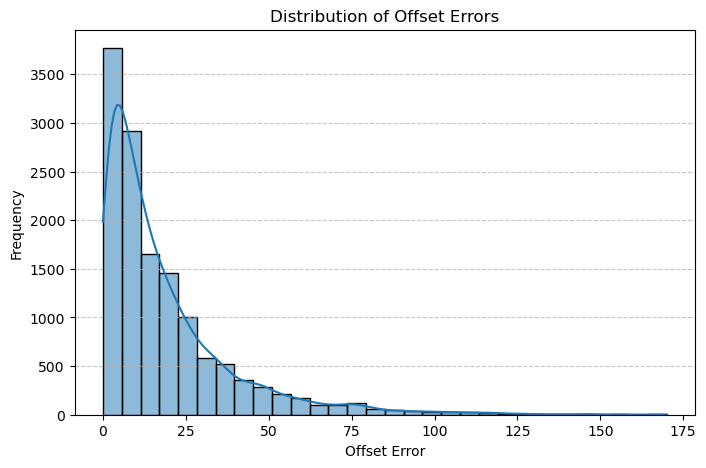

In [17]:
show_errors(xgboost_errors)

# Deep Learning model
For this project, we will create a neural network with MSE loss function

### Neural Network Utils

#### Training Utils
This section includes the train loop

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch

# Early stopping parameters
def train_nn(model, optimizer, criterion, val_loader, train_loader, train_size, val_size):
    patience = 7  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    metrics_history = []
    num_epochs = 25

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        # Training phase
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()               # Reset gradients
            outputs = model(batch_X)              # Forward pass
            loss = criterion(outputs, batch_y)    # Compute loss
            loss.backward()                       # Backpropagation
            optimizer.step()                      # Update parameters
            running_train_loss += loss.item() * batch_X.size(0)
        
        train_loss = running_train_loss / train_size

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_preds = []
        all_true = []
        with torch.no_grad():
            for val_X, val_y in val_loader:
                outputs = model(val_X)
                loss = criterion(outputs, val_y)
                running_val_loss += loss.item() * val_X.size(0)
                all_preds.extend(outputs.squeeze().cpu().numpy())
                all_true.extend(val_y.squeeze().cpu().numpy())
        
        val_loss = running_val_loss / val_size

        # Compute additional regression metrics on the validation set.
        mse = mean_squared_error(all_true, all_preds)
        mae = mean_absolute_error(all_true, all_preds)
        r2 = r2_score(all_true, all_preds)

        # Save the metrics for this epoch in a dictionary.
        epoch_metrics = {
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_mse': mse,
            'val_mae': mae,
            'val_r2': r2
        }
        metrics_history.append(epoch_metrics)

        # Print the metrics for the epoch.
        print(f"Epoch {epoch+1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
            f"MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement for {patience} consecutive epochs.")
            break
        
    return metrics_history

#### Testing Utils
This section include the compare function, and test page/model functions

In [19]:
import torch
import pandas as pd
import numpy as np

def compare_hotels_nn(model, columns) :
    def compare(hotel1, hotel2):
        """
        Compare two hotels using a trained PyTorch regression model.
        
        Parameters:
        hotel1, hotel2: pd.Series
            Series containing the hotel data. These should have the same indices.
        scaler: sklearn.preprocessing object, optional
            The scaler used to transform training features. If provided, the input 
            features will be scaled using scaler.transform().
        
        Returns:
        prediction: float
            The predicted index difference (hotel1_index - hotel2_index) from the model.
        """
        # Process each hotel using your helper function.
        hotel1_processed = drop_relevant_columns(hotel1)
        hotel2_processed = drop_relevant_columns(hotel2)
        
        # Ensure that both processed hotels are pandas Series.
        if not (isinstance(hotel1_processed, pd.Series) and isinstance(hotel2_processed, pd.Series)):
            raise ValueError("drop_relevant_columns must return a pandas Series for each hotel.")
        
        # Create a dictionary combining the two hotels.
        pair_dict = {}
        for col in hotel1_processed.index:
            pair_dict[f'hotel1_{col}'] = hotel1_processed[col]
            pair_dict[f'hotel2_{col}'] = hotel2_processed[col]
        
        # Build a DataFrame from the dictionary.
        try:
            pair_df = pd.DataFrame([pair_dict])[columns]
        except Exception as e:
            raise ValueError("Error constructing DataFrame from the hotel data.") from e


        pair_df = pd.DataFrame(scaler_X.transform(pair_df), columns=pair_df.columns)
        
        # Convert the DataFrame to a PyTorch tensor.
        X_tensor = torch.tensor(pair_df.values.astype(np.float32))
        
        # Set the model to evaluation mode and get the prediction.
        model.eval()
        with torch.no_grad():
            output = model(X_tensor)
        
        # Assuming the output is of shape [1, 1], return a scalar.
        prediction = output.item()
        return prediction
    
    return compare


In [20]:
from functools import cmp_to_key
def test_page_error_nn(model,columns, page):
    shuffeled_page = shuffle_page(page)
    hotels_list = [hotel for _, hotel in shuffeled_page.iterrows()]

    # Sort using the inverted comparator
    sorted_hotels = sorted(hotels_list, key=cmp_to_key(compare_hotels_nn(model, columns)))

    errors = []
    for new_index, sorted_hotel in enumerate(sorted_hotels):
        squared_error = (new_index - sorted_hotel['hotel_index']) ** 2
        errors.append(squared_error)
    
    return errors

In [21]:
from joblib import Parallel, delayed, parallel_backend
from itertools import chain
from os import cpu_count


num_of_cores = cpu_count()
max_jobs = num_of_cores // 4

def test_model_nn(model, columns):
    with parallel_backend('threading'):
        errors_list = Parallel(max_jobs)(delayed(test_page_error_nn)(model, columns,page) for _, page in test_pages)
        # flatten errors list
        errors = pd.Series(chain(*errors_list))

        return errors
    
    return []

## Neural Network

### Data Preprocessing

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler

nn_columns = xgboost_regressor_columns

data = train_pairs.copy().reset_index(drop=True)
data['index_difference'] = (train_pairs['hotel1_hotel_index'] - train_pairs['hotel2_hotel_index']).reset_index(drop=True, inplace=False)
data = data.dropna()

X_train = data[nn_columns].astype(np.float32)
scaler_X = StandardScaler()
features = scaler_X.fit_transform(X_train)
X = torch.from_numpy(features)

target = np.array(data[['index_difference']].astype(np.float32))
scaler_y = StandardScaler()
target = scaler_y.fit_transform(target.reshape(-1, 1)).flatten()
y = torch.from_numpy(target).unsqueeze(1) 

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [23]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [24]:
print("Any NaNs in features?", np.isnan(features).sum())
print("Any infs in features?", np.isinf(features).any())
print("Any NaNs in target?", np.isnan(target).any())
print("Any infs in target?", np.isinf(target).any())

Any NaNs in features? 0
Any infs in features? False
Any NaNs in target? False
Any infs in target? False


In [25]:
input_size = X.shape[1]
hidden_size1 = 64
hidden_size2 = 32

model_nn = nn.Sequential(
    nn.Linear(input_size, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, 1)  # Output a single value for regression
)

In [26]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001, weight_decay=0.0001)

In [27]:
train_nn(model_nn, optimizer, criterion, val_loader, train_loader, train_size, val_size)

Epoch 1/25 | Train Loss: 0.5331 | Val Loss: 0.3522 | MSE: 0.3522 | MAE: 0.4510 | R2: 0.6483
Epoch 2/25 | Train Loss: 0.3287 | Val Loss: 0.3092 | MSE: 0.3092 | MAE: 0.4187 | R2: 0.6913
Epoch 3/25 | Train Loss: 0.3010 | Val Loss: 0.2985 | MSE: 0.2985 | MAE: 0.4094 | R2: 0.7020
Epoch 4/25 | Train Loss: 0.2899 | Val Loss: 0.2931 | MSE: 0.2931 | MAE: 0.4042 | R2: 0.7074
Epoch 5/25 | Train Loss: 0.2827 | Val Loss: 0.2783 | MSE: 0.2783 | MAE: 0.3918 | R2: 0.7221
Epoch 6/25 | Train Loss: 0.2770 | Val Loss: 0.2839 | MSE: 0.2839 | MAE: 0.4001 | R2: 0.7165
Epoch 7/25 | Train Loss: 0.2731 | Val Loss: 0.2643 | MSE: 0.2643 | MAE: 0.3806 | R2: 0.7361
Epoch 8/25 | Train Loss: 0.2704 | Val Loss: 0.2711 | MSE: 0.2711 | MAE: 0.3885 | R2: 0.7293
Epoch 9/25 | Train Loss: 0.2685 | Val Loss: 0.2630 | MSE: 0.2630 | MAE: 0.3804 | R2: 0.7374
Epoch 10/25 | Train Loss: 0.2673 | Val Loss: 0.2671 | MSE: 0.2671 | MAE: 0.3848 | R2: 0.7333
Epoch 11/25 | Train Loss: 0.2656 | Val Loss: 0.2643 | MSE: 0.2643 | MAE: 0.3809

[{'epoch': 1,
  'train_loss': 0.5330933576935805,
  'val_loss': 0.3522354736107214,
  'val_mse': 0.35223547343243605,
  'val_mae': 0.4510452346422312,
  'val_r2': 0.6483103361770053},
 {'epoch': 2,
  'train_loss': 0.3287456040770134,
  'val_loss': 0.3092287409855765,
  'val_mse': 0.3092287411203174,
  'val_mae': 0.4186663813553374,
  'val_r2': 0.6912504270247142},
 {'epoch': 3,
  'train_loss': 0.3009923558297667,
  'val_loss': 0.2984963881523279,
  'val_mse': 0.29849638759777797,
  'val_mae': 0.4094400891305049,
  'val_r2': 0.7019661501334357},
 {'epoch': 4,
  'train_loss': 0.28990050321006505,
  'val_loss': 0.2930530629065408,
  'val_mse': 0.2930530625229418,
  'val_mae': 0.40419944368713273,
  'val_r2': 0.7074010404555077},
 {'epoch': 5,
  'train_loss': 0.2827327763232845,
  'val_loss': 0.2783454641155732,
  'val_mse': 0.2783454642413822,
  'val_mae': 0.39183048002633497,
  'val_r2': 0.7220858484473908},
 {'epoch': 6,
  'train_loss': 0.2769747396553354,
  'val_loss': 0.28391848545763

In [28]:
model_nn_errors = test_model_nn(model_nn, nn_columns)
model_nn_errors.describe()


count    13533.000000
mean      1009.205941
std       2210.269930
min          0.000000
25%         49.000000
50%        256.000000
75%        961.000000
max      28561.000000
dtype: float64

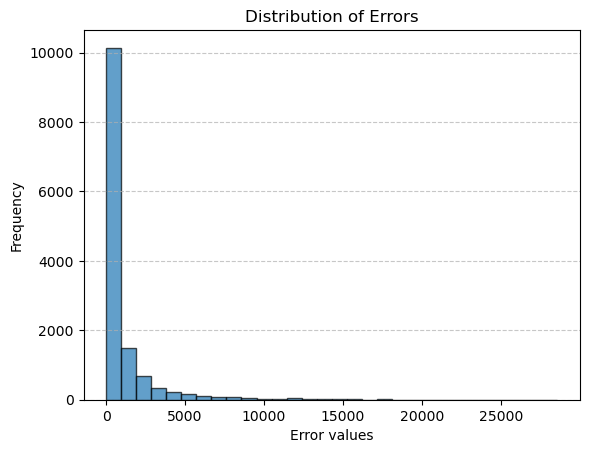

In [29]:
# show errors
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

model_nn_errors.plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Error values')
plt.ylabel('Frequency')
plt.title('Distribution of Errors')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

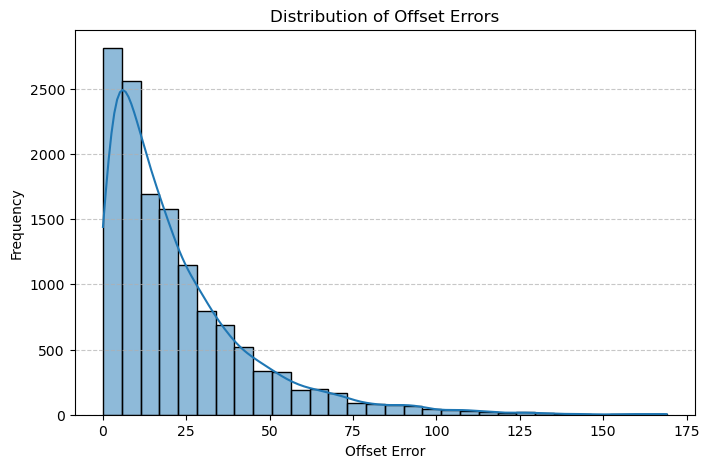

In [30]:
show_errors(model_nn_errors)

# Conclusion


In [31]:
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Example: List of Pandas Series containing squared errors
squared_errors_list = [
    xgboost_errors,
    model_nn_errors
]

# Model names
names = [
    "XGBoost",
    "Neural Network"
]# Custom labels

# Convert squared errors to offset errors (recover sign)
offset_errors_list = [np.sign(series.index) * np.sqrt(series.values) for series in squared_errors_list]

# Flatten data for KDE plot (Plotly requires a list of lists)
offset_errors_flat = [list(errors) for errors in offset_errors_list]

# Create figure
fig = go.Figure()

# Add Histograms
for i, offset_errors in enumerate(offset_errors_list):
    fig.add_trace(go.Histogram(
        x=offset_errors,
        name=names[i],
        opacity=0.5,
        histnorm="probability density",  # Normalize histogram
        nbinsx=30
    ))

# Add KDE (Density Plot)
fig_kde = ff.create_distplot(offset_errors_flat, names, show_hist=False, show_rug=False)
for trace in fig_kde.data:
    fig.add_trace(trace)

# Customize layout
fig.update_layout(
    title="Histogram & Density Distribution of Offset Errors",
    xaxis_title="Offset Error",
    yaxis_title="Density",
    barmode="overlay",  # Overlapping histograms
    template="plotly_white"
)

fig.show()


### Final Verdict

While both models did not perform as well as their counterparts of booking's sorter, the differences between them remain the same: XGBoost out performs the neural network.

while the neural network it self showed a great validation metrics while training, it did not perform as good on the sorting test it self.